# Physical-Informed model of well

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
# import wandb

import zipfile

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Pre-processing dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd /content/drive/MyDrive/ml

In [3]:
path = '/content/drive/MyDrive/datafinns/'

In [8]:
with zipfile.ZipFile("/content/drive/MyDrive/datafinns/final arch.zip","r") as z:
    z.extractall(".")


In [13]:
perm = np.load('perms_clear.npy')[0:504]
pressure = np.load('pressures_clear.npy')[0:504]

In [14]:
perm.shape

(504, 64, 64)

In [15]:
pressure.shape

(504, 21, 64, 64)

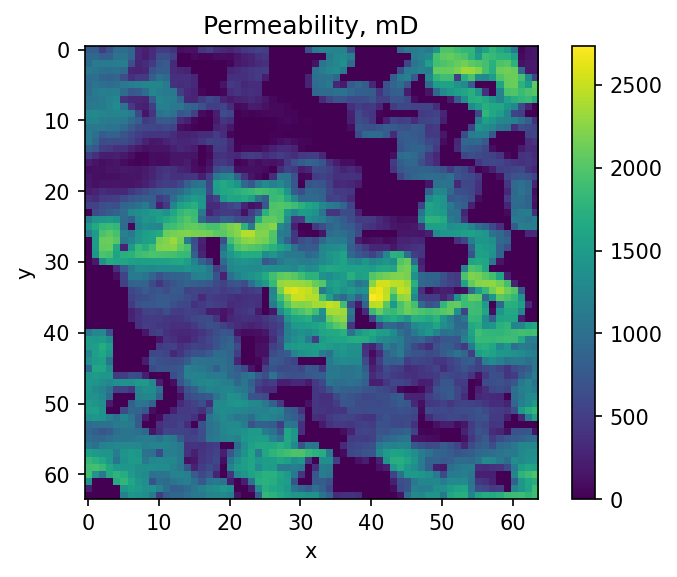

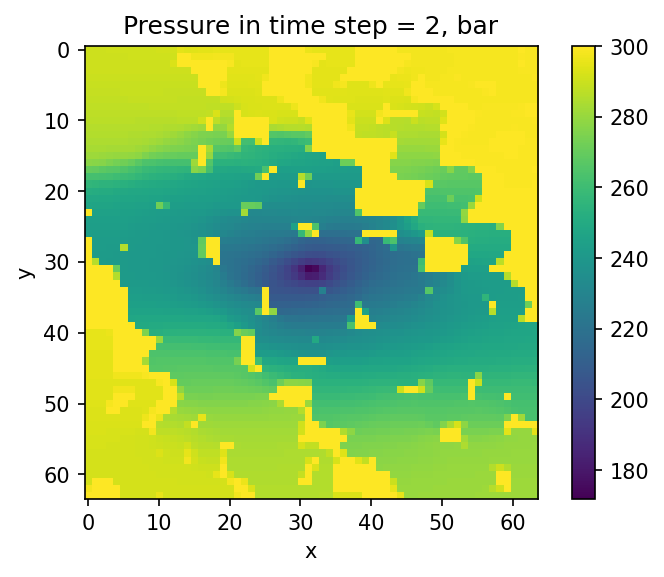

In [16]:
plt.figure(dpi=150)
plt.imshow(perm[1])
plt.subplots_adjust()
plt.colorbar()
plt.title('Permeability, mD')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(dpi=150)
i = 2
plt.imshow(pressure[1][i])
plt.subplots_adjust()
plt.colorbar()
plt.title(f'Pressure in time step = {i}, bar')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Dataset

In [21]:
x, y = [], []
for i in tqdm(range(len(pressure))):
    for j in range(len(pressure[i])):
        inp = np.stack((perm[i], np.ones((64,64))*j))
        x.append(inp)
        out = np.reshape(pressure[i][j],(1,64,64))
        y.append(out)
x = np.stack(tuple(x))
y = np.stack(tuple(y))

100%|██████████| 504/504 [00:00<00:00, 869.36it/s]


In [22]:
print(f'x shape {x.shape}\ny shape {y.shape}')

x shape (10584, 2, 64, 64)
y shape (10584, 1, 64, 64)


In [23]:
# x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
# x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
total_size = x.shape[0]
bs = 21
total_batches = total_size / bs
train_test_split_values = np.floor(np.array([0.8, 0.1, 0.1]) * total_batches) * bs
ths = train_test_split_values.astype(int)
print(ths)

x_train = x[0:ths[0]]
y_train = y[0:ths[0]]
x_val = x[ths[0]:ths[0]+ths[1]]
y_val = y[ths[0]:ths[0]+ths[1]]
x_test = x[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]
y_test = y[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]


print(f'The train size {len(x_train)}',
      f'\nThe val size {len(x_val)}',
     f'\nThe test size {len(x_test)}')

x_train = torch.from_numpy(x_train).to(device)
x_val = torch.from_numpy(x_val).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_val = torch.from_numpy(y_val).to(device)
y_test = torch.from_numpy(y_test).to(device)

[8463 1050 1050]
The train size 8463 
The val size 1050 
The test size 1050


In [24]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=len(x_test), shuffle=False, num_workers=0)

# Model architecture

In [25]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
#         return torch.sigmoid(self.conv(dec1))
        return self.conv(dec1)


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [26]:
# from torchsummary import summary

# summary(model, input_size=(2,64, 64))

# Adding losses

In [27]:
def loss_data(h_real, h_pred):
    return torch.mean(torch.square(h_real - h_pred))

In [28]:
def torch_gradient(input, h, dx=200, dy=100):

    dhx, dhy = torch.gradient(h, spacing=(dx, dy), dim=(2, 3))
    Kdhx = input[:, 0, :, :].view(-1, 1, 64, 64) * dhx
    Kdhy = input[:, 0, :, :].view(-1, 1, 64, 64) * dhy
    
    dKdhx = torch.gradient(Kdhx, spacing=dx, dim=2)[0]
    dKdhy = torch.gradient(Kdhy, spacing=dy, dim=3)[0]

    return dKdhx + dKdhy

In [29]:
def hdt(h, S=5, dt=365*86400):
    partial_t = S * torch.gradient(h, spacing=dt, dim=0)[0]
    return partial_t

In [30]:
def loss_pde(input, h_pred, dx=200, dy=100, S=1e-4, dt=365*86400):
    nabla_K_nabla_h = torch_gradient(input, h_pred, dx=dx, dy=dy)
    # Sdhdt = hdt(h_pred, S=S, dt=dt)
    return torch.mean(torch.square(nabla_K_nabla_h))

## Model training

# PDE

In [34]:
model = UNet(in_channels=2, out_channels=1, init_features=64)

logging = []
mltplr = 1e3

def train(model, opt, criterion, n_epochs, scheduler):

    min_val_loss = np.inf
    for epoch in range(n_epochs):
        model.train()
        
        train_batch_loss = []
        train_batch_data_loss = []
        train_batch_pde_loss = []
        for batch in train_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = pde_loss
            if torch.isnan(loss):
                break
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            train_batch_data_loss.append(data_loss.item())
            train_batch_pde_loss.append(pde_loss.item())

        train_loss = np.mean(train_batch_loss)
        train_data_loss = np.mean(train_batch_data_loss)
        train_pde_loss = np.mean(train_batch_pde_loss)
    
        model.eval()
        
        val_batch_loss = []
        val_batch_data_loss = []
        val_batch_pde_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = pde_loss

            val_batch_loss.append(loss.item())
            val_batch_data_loss.append(data_loss.item())
            val_batch_pde_loss.append(pde_loss.item())
            
        val_loss = np.mean(val_batch_loss)
        val_data_loss = np.mean(val_batch_data_loss)
        val_pde_loss = np.mean(val_batch_pde_loss)

        scheduler.step(val_loss)
               
        logging.append(np.array([epoch, train_loss, train_data_loss, train_pde_loss, val_loss, val_data_loss, val_pde_loss]))
        if val_loss > min_val_loss:
            f+=1
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
        else:
            print(f'epoch: {epoch}, val loss did decrease, saving model')
            f=0
            folder = path
            model_name_cur = f'PINN_non_steady_PDE_ONLY_v2_current.pth'
            model_path = folder + model_name_cur
            torch.save(model, model_path)
            min_val_loss = val_loss
        
        if f>=10:
            break
        
        print(f'epoch: {epoch}, TRAIN_LOSS: [TOTAL: {round(train_loss, 1)} DATA: {round(train_data_loss, 1)}, PDE: {train_pde_loss}], \tVAL LOSS: [TOTAL: TOTAL: {round(val_loss, 1)} DATA: {round(val_data_loss, 1)}, PDE: {val_pde_loss}]')
        # wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        
        # если в течение 10 эпох ошибка на валидации не уменьшается, то прерываем обучение

# wandb.init(project="PINN_non_steady_1000_epoch_early_stop_sch")

'''
if torch.cuda.device_count() > 1:
    print("GPUs:", torch.cuda.device_count())
    model = nn.DataParallel(model, device_ids=[2, 3])
'''

model = UNet(in_channels=2, out_channels=1, init_features=64)
model.to(device)
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
criterion = nn.MSELoss()

train(model, opt, criterion, n_epochs, scheduler=scheduler)

epoch: 0, val loss did decrease, saving model
epoch: 0, TRAIN_LOSS: [TOTAL: 0.0 DATA: 57680.0, PDE: 0.0035906392796338877], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 60518.7, PDE: 4.830069730815012e-05]
epoch: 1, val loss did decrease, saving model
epoch: 1, TRAIN_LOSS: [TOTAL: 0.0 DATA: 57691.9, PDE: 2.792718816328971e-05], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 60527.5, PDE: 1.6826109404064483e-05]
epoch: 2, val loss did decrease, saving model
epoch: 2, TRAIN_LOSS: [TOTAL: 0.0 DATA: 57698.1, PDE: 1.1707091575896336e-05], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 60532.6, PDE: 8.491574135405244e-06]
epoch: 3, val loss did decrease, saving model
epoch: 3, TRAIN_LOSS: [TOTAL: 0.0 DATA: 57702.2, PDE: 6.692059723853966e-06], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 60536.3, PDE: 5.6471870993846095e-06]
epoch: 4, val loss did decrease, saving model
epoch: 4, TRAIN_LOSS: [TOTAL: 0.0 DATA: 57705.4, PDE: 4.275900291149833e-06], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 60539.2, PDE: 3.6474226430982525e-06]
epoch: 5, v

KeyboardInterrupt: ignored

100%|██████████| 1050/1050 [00:07<00:00, 141.41it/s]


60008.23887834822


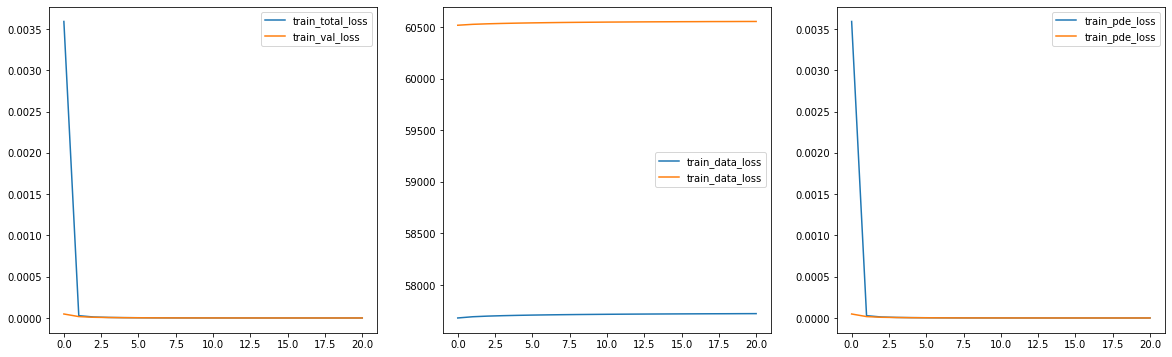

In [35]:
logging = np.array(logging)
np.save('logging_PDE_v2.npy',logging)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.plot(logging[:,0], logging[:,1], label='train_total_loss')
ax1.plot(logging[:,0], logging[:,4], label='train_val_loss')
ax1.legend()

ax2.plot(logging[:,0], logging[:,2], label='train_data_loss')
ax2.plot(logging[:,0], logging[:,5], label='train_data_loss')
ax2.legend()

ax3.plot(logging[:,0], logging[:,3], label='train_pde_loss')
ax3.plot(logging[:,0], logging[:,6], label='train_pde_loss')
ax3.legend()

test_loss = []

for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
    pred = model(sample.unsqueeze(0))
    loss = criterion(pred[0], target)
    test_loss.append(loss.item())

print(np.mean(test_loss))

# model_path_cur = folder'PINN_non_steady_PDE_ONLY_v2_current.pth'
# model = torch.load(model_path_cur)
# model.to(device)
# model.eval()

# for batch in test_loader:
#     sample, target = batch
#     sample, target = sample.to(device, torch.float), target.to(device, torch.float)

# with torch.no_grad():
#     pred = model(sample)
#     test_data_loss = loss_data(target, pred)
#     test_pde_loss = mltplr*loss_pde(sample, pred)
#     test_total_loss = test_pde_loss # + pde_loss
    
# test_data_loss, test_pde_loss, test_total_loss = test_data_loss.cpu().numpy(), test_pde_loss.cpu().numpy(), test_total_loss.cpu().numpy()
    
# fig, axes = plt.subplots(3, 11, figsize=(31, 6))
# vmin, vmax = 220, 300
# for i in range(11):
#     axes[0, i].set_title(f'Time step = {i}')
#     axes[0, 0].set_ylabel('Target')
#     axes[1, 0].set_ylabel('Pred')
#     axes[2, 0].set_ylabel('Diff')
#     tar = target[i, 0, :, :].cpu().numpy()
#     pre = pred[i, 0, :, :].detach().cpu().numpy()
#     diff = tar - pre
#     sc = axes[0, i].imshow(tar, vmin=vmin, vmax=vmax)
#     fig.colorbar(sc, ax=axes[0, i])
#     sc = axes[1, i].imshow(pre, vmin=vmin, vmax=vmax)
#     fig.colorbar(sc, ax=axes[1, i])
#     sc = axes[2, i].imshow(diff, vmin=-20, vmax=20)
#     fig.colorbar(sc, ax=axes[2, i])

# print(f'TEST_LOSS: [TOTAL: {np.round(test_total_loss, 1)} DATA: {np.round(test_data_loss, 1)}, PDE: {np.round(test_pde_loss, 1)}]')

In [36]:
def one_prediction_with_x(idx):
    ex_x, ex_y = test_dataset[idx]
    ex_pred = model(ex_x.unsqueeze(0).to(device, dtype=torch.float)).cpu().detach().numpy()[0]
    target = ex_y.cpu().numpy()[0]
    pred = ex_pred[0]
    diff = ex_y.cpu().numpy()[0] - ex_pred[0]
    return target, pred, diff, ex_x.cpu().numpy()[0]

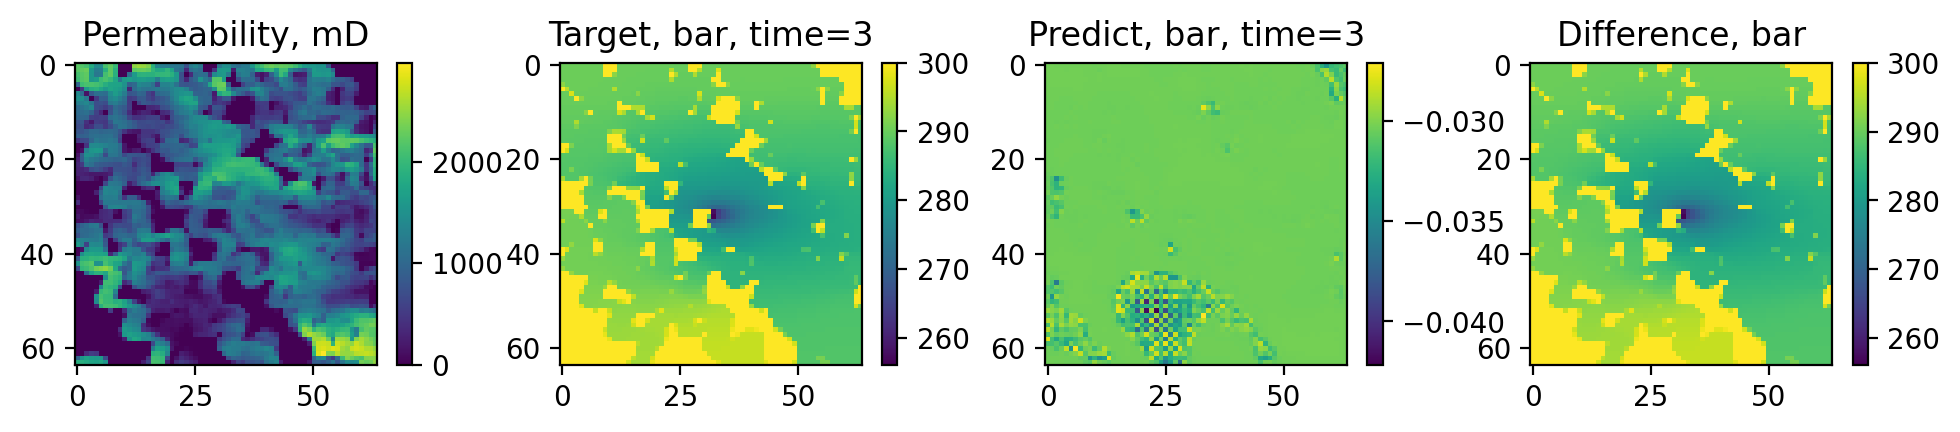

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(12,2), dpi=200)
target, pred, diff, k = one_prediction_with_x(4)
true = axes[0].imshow(k)
axes[0].set_title(f'Permeability, mD')
fig.colorbar(true, ax=axes[0])
true = axes[1].imshow(target, vmin = np.min(target), vmax = np.max(target))
axes[1].set_title(f'Target, bar, time={3}')
fig.colorbar(true, ax=axes[1])
true = axes[2].imshow(pred, vmin = np.min(pred), vmax = np.max(pred))
axes[2].set_title(f'Predict, bar, time={3}')
fig.colorbar(true, ax=axes[2])
true = axes[3].imshow(diff)
axes[3].set_title(f'Difference, bar')
fig.colorbar(true, ax=axes[3])
plt.show()